In [1]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import country_converter as cc
from sklearn.linear_model import LinearRegression

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [176]:
data = pd.read_csv("../data/processed/drought-agtfp-gdp-data.csv")
print(len(data))

11387


# Drought - Ag. TfP

## remove missing rows

In [177]:
# countries_to_keep = set(["AZE","DZA","GRC", "ESP"])
countries_to_keep = set(["AZE", "DZA"])
# for country in set(data.country):
#     if cc.convert(names=[country], to="Continent") == "Europe":
#         countries_to_keep.add(country)
indices_to_drop = []
no_nan_cols = ["ln_TFP_change"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
    elif row.country not in countries_to_keep:
        indices_to_drop.append(index)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(len(data))

108


## Scale dependent variable

In [178]:
tfp_scaler = StandardScaler()
tfp_scaled = tfp_scaler.fit_transform(np.array(data.ln_TFP_change).reshape(-1,1)).flatten()

## linear regression to get a sense of good priors

In [166]:
x = np.array(data.drought).reshape(-1,1)
y = np.array(tfp_scaled).reshape(-1,1)
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[0.21305808]] [-0.00394552]


In [167]:
import statsmodels.api as sm
ols = sm.OLS(tfp_scaled,x)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.018
Method:                 Least Squares   F-statistic:                            0.04295
Date:                Thu, 04 Apr 2024   Prob (F-statistic):                       0.837
Time:                        17:24:14   Log-Likelihood:                         -76.601
No. Observations:                  54   AIC:                                      155.2
Df Residuals:                      53   BIC:                                      157.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2091      1.009      0.207      0.837      -1.815       2.233
==============================================================================
Omnibus:                       11.802   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.250
Skew:                          -0.818   Prob(JB):                     0.000805
Kurtosis:                       4.912   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## country-specific linear regression

In [197]:
country_specific_data = {"country":[],"coef":[]}
curr_country = ""
curr_country_drought_data = []
curr_country_tfp_data = []
for index, row in enumerate(data.itertuples()):
    if row.country != curr_country:
        if curr_country != "":
            x = np.array(curr_country_drought_data).reshape(-1,1)
            y = np.array(curr_country_tfp_data).reshape(-1,1)
            model = LinearRegression().fit(x,y)
            country_specific_data["country"].append(curr_country)
            country_specific_data["coef"].append(model.coef_[0][0])
        curr_country = row.country
        curr_country_drought_data = []
        curr_country_tfp_data = []
    curr_country_drought_data.append(row.drought)
    curr_country_tfp_data.append(tfp_scaled[index])
x = np.array(curr_country_drought_data).reshape(-1,1)
y = np.array(curr_country_tfp_data).reshape(-1,1)
model = LinearRegression().fit(x,y)
country_specific_data["country"].append(curr_country)
country_specific_data["coef"].append(model.coef_[0][0])
country_specific_data = pd.DataFrame.from_dict(country_specific_data)
print(country_specific_data)
print(np.mean(country_specific_data.coef))
print(np.std(country_specific_data.coef))

  country      coef
0     AZE  1.797853
1     DZA  0.233404
1.015628140176092
0.7822246343769426


## make colored world map based on country-specific regression results

In [37]:
import geopandas
import folium
country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    country_specific_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
world_map = folium.Map()
folium.Choropleth(
    geo_data=country_geopandas,
    name='choropleth',
    data=country_geopandas,
    columns=['country', 'coef'],
    key_on='feature.properties.country',
    fill_color="RdYlGn",
    nan_fill_color='Grey',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(world_map)
world_map.save("../figures/drought_response_map_scaled.html")

/tmp/ipykernel_4593/3422463595.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


## create fixed effect matrices

In [179]:
min_year = min(data.year)
data_len = len(data.year)
year_fixed_effect_matrix = [np.zeros(data_len) for year in set(data.year)]
country_fixed_effect_matrix = [np.zeros(data_len) for country in set(data.country)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.country != curr_country:
        country_index += 1
        curr_country = row.country
    year_index = row.year - min_year
    country_fixed_effect_matrix[country_index][row_index] = 1
    year_fixed_effect_matrix[year_index][row_index] = 1

## create gradual effect matrices

In [88]:
data_len = len(data.year)
country_counters = {}
country_grad_effect_matrix = [np.zeros(data_len) for country in set(data.country)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.country != curr_country:
        country_index += 1
        curr_country = row.country
        if curr_country not in country_counters:
            country_counters[curr_country] = 1
    country_grad_effect_matrix[country_index][row_index] = country_counters[curr_country]
    country_counters[curr_country] += 1

## build hierarchical model

In [192]:
with pm.Model() as model:

    global_coef_prior_mean = pm.Normal("global_coef_prior_mean", 0, 5)
    global_coef_prior_sd = pm.HalfNormal("global_coef_prior_sd", 5)
    
    # country_coef_prior_means = pt.expand_dims(pm.Normal("country_coef_prior_means", global_coef_prior_mean, global_coef_prior_sd, shape=(len(set(data.country)))),axis=1)
    # country_coef_priors = pm.Deterministic("country_coef_priors", pt.sum(country_coef_prior_means*country_fixed_effect_matrix,axis=0))

    # country_coef_prior_sd = pm.HalfNormal("country_coef_prior_sd", 5)    
    
    # drought_tfp_coef = pm.Normal("drought_tfp_coef", country_coef_priors, country_coef_prior_sd)
    drought_tfp_coef = pt.expand_dims(pm.Normal("drought_tfp_coef", global_coef_prior_mean, global_coef_prior_sd, shape=(len(set(data.country)))),axis=1)
    drought_tfp_coef = pm.Deterministic("drought_tfp_coefs", pt.sum(drought_tfp_coef*country_fixed_effect_matrix,axis=0))
    # drought_tfp_coef = pm.Normal("drought_tfp_coef", 0, 5)
    
    intercept = pm.Normal("intercept", 0, 5)

    # year_fixed_effect_coefs = pt.expand_dims(pm.Normal("year_fixed_effect_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    # year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_fixed_effect_coefs*year_fixed_effect_matrix,axis=0))

    # country_fixed_effect_coefs = pt.expand_dims(pm.Normal("country_fixed_effect_coefs", 0, 10, shape=(len(set(data.country)))),axis=1)
    # country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_fixed_effect_coefs*country_fixed_effect_matrix,axis=0))

    # country_grad_effect_coefs = pt.expand_dims(pm.Normal("country_grad_effect_coefs", 0, 10, shape=(len(set(data.country)))),axis=1)
    # country_grad_effects = pm.Deterministic("grad_effects",pt.sum(country_grad_effect_coefs*country_grad_effect_matrix,axis=0))
    
    tfp_prior = pm.Normal(
        "tfp_prior", 
        (drought_tfp_coef * data.drought) + 
        # country_fixed_effects +
        # year_fixed_effects + 
        # country_grad_effects +
        intercept
    )

    tfp_sd = pm.HalfNormal("tfp_sd", 5)
    tfp_posterior = pm.Normal("tfp_posterior", tfp_prior, tfp_sd, observed = tfp_scaled)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [drought_tfp_coef, global_coef_prior_mean, global_coef_prior_sd, intercept, tfp_posterior, tfp_prior, tfp_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_coef_prior_mean, global_coef_prior_sd, drought_tfp_coef, intercept, tfp_prior, tfp_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 199 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [tfp_posterior]


## read model from file

In [2]:
model = pd.read_pickle('../models/extreme_weather/drought-agtfp-hierarchical-regression-coef.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
tfp_scaler = model["tfp_scaler"]

## trace plots

In [149]:
az.summary(trace, var_names=["global_coef_prior_mean", "global_coef_prior_sd", "country_coef_prior_sd", "intercept", "tfp_sd"])

KeyError: 'var names: "[\'country_coef_prior_sd\'] are not present" in dataset'

In [196]:
az.summary(trace, var_names=["global_coef_prior_mean","global_coef_prior_sd"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_coef_prior_mean,0.897,1.808,-3.235,3.938,0.051,0.036,1302.0,1499.0,1.0
global_coef_prior_sd,2.338,2.058,0.034,5.983,0.073,0.052,643.0,1064.0,1.0


In [195]:
az.summary(trace, var_names=["drought_tfp_coef"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
drought_tfp_coef[0],1.420,0.976,-0.404,3.226,0.026,0.019,1385.0,2108.0,1.0
drought_tfp_coef[1],0.584,0.963,-1.362,2.242,0.024,0.019,1583.0,2005.0,1.0


/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/tmp/ipykernel_4593/1366245557.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


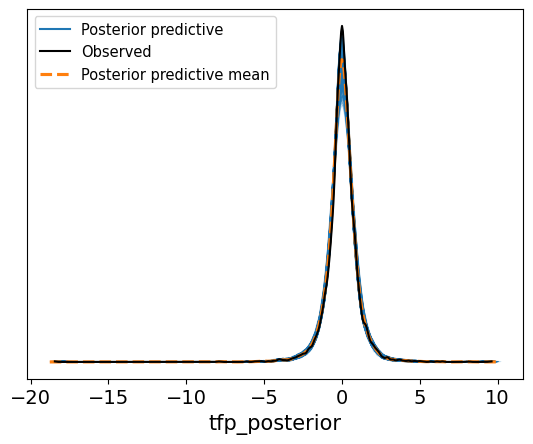

In [7]:
fig = az.plot_ppc(posterior,var_names=["tfp_posterior"]).figure
fig.show()

/tmp/ipykernel_74757/566205160.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


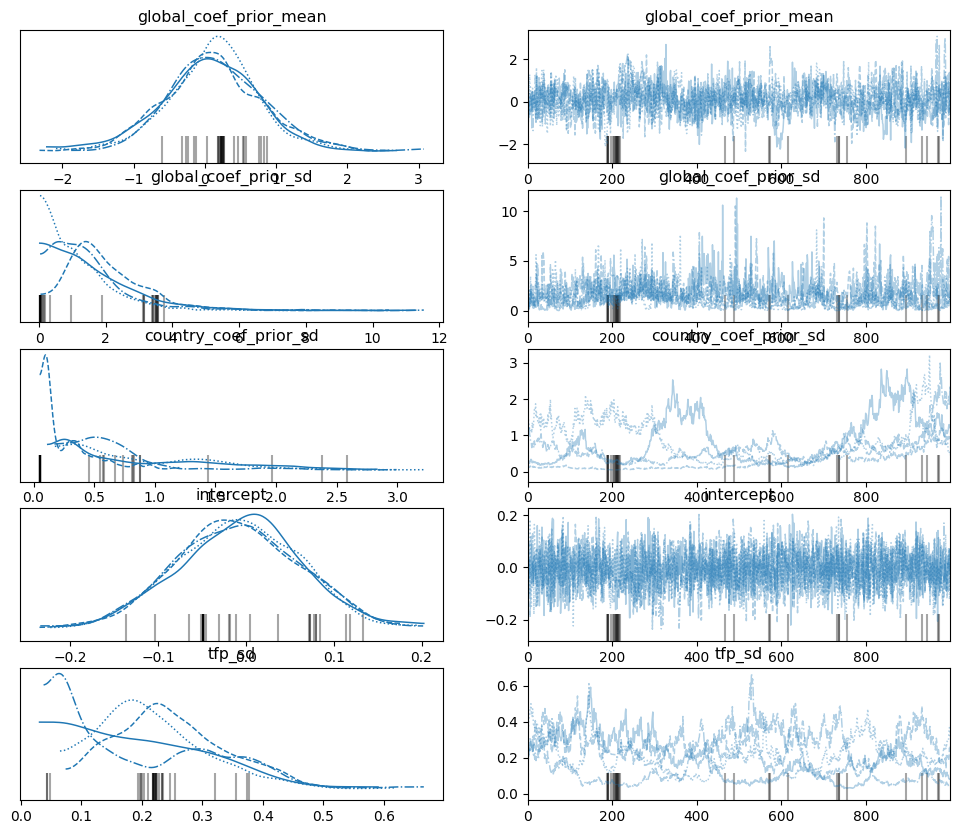

In [25]:
fig = az.plot_trace(trace, var_names=["global_coef_prior_mean", "global_coef_prior_sd", "country_coef_prior_sd", "intercept", "tfp_sd"]).ravel()[0].figure
fig.show()

# create dataset

In [41]:
integrated_data_dict = {
    "country":[],
    "year":[],
    "drought":[],
    "extreme_temperature":[],
    "flood":[],
    "ln_GDP_change":[],
    "ln_TFP_change":[]
}

burke_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
ortizbobea_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
extreme_weather_data = pd.read_csv("../data/global_data/extreme_weather_events.csv")

all_countries = sorted((set(ortizbobea_data["ISO3"]).union(set(burke_data["iso"]))).intersection(set(extreme_weather_data["ISO"])))
all_years = sorted(set(ortizbobea_data["year"]).union(set(burke_data["year"])).union(set([int(year.split("-")[0]) for year in extreme_weather_data["DisNo."]])))

for index, country in enumerate(list(all_countries)):
    for year in all_years:
        burke_row = burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]
        ob_row = ortizbobea_data.loc[(ortizbobea_data["ISO3"] == country) & (ortizbobea_data["year"] == year)]
        ew_rows = extreme_weather_data.loc[(extreme_weather_data["DisNo."].str.startswith(str(year), na=False)) & (extreme_weather_data["ISO"] == country)]
        integrated_data_dict["country"].append(country)
        integrated_data_dict["year"].append(year)
        try:
            integrated_data_dict["ln_TFP_change"].append(ob_row["fd_log_tfp"].item())
        except ValueError:
            integrated_data_dict["ln_TFP_change"].append(np.NaN)
        try:
            integrated_data_dict["ln_GDP_change"].append(burke_row["growthWDI"].item())
        except ValueError:
            integrated_data_dict["ln_GDP_change"].append(np.NaN)
        for disaster_type in ["Flood","Drought","Extreme temperature"]:
            if len(ew_rows) == 0:
                integrated_data_dict[disaster_type.lower().replace(" ","_")].append(0)
            else:
                if any(ew_row["Disaster Type"] == disaster_type for _, ew_row in ew_rows.iterrows()):
                    integrated_data_dict[disaster_type.lower().replace(" ","_")].append(1)
                else:
                    integrated_data_dict[disaster_type.lower().replace(" ","_")].append(0)
pd.DataFrame.from_dict(integrated_data_dict).to_csv("../data/processed/drought-agtfp-gdp-data.csv", index=False)    